总内存 16110.78515625
已使用内存 12605.80078125
剩余内存 3504.984375
内存使用率 78.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000608 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5631
[LightGBM] [Info] Number of data points in the train set: 11109, number of used features: 26
[LightGBM] [Info] Start training from score -1.025720
[LightGBM] [Info] Start training from score -3.311624
[LightGBM] [Info] Start training from score -2.455896
[LightGBM] [Info] Start training from score -2.817229
[LightGBM] [Info] Start training from score -4.958802
[LightGBM] [Info] Start training from score -1.178700
[LightGBM] [Info] Start training from score -3.258727
[LightGBM] [Info] Start training from score -2.241394


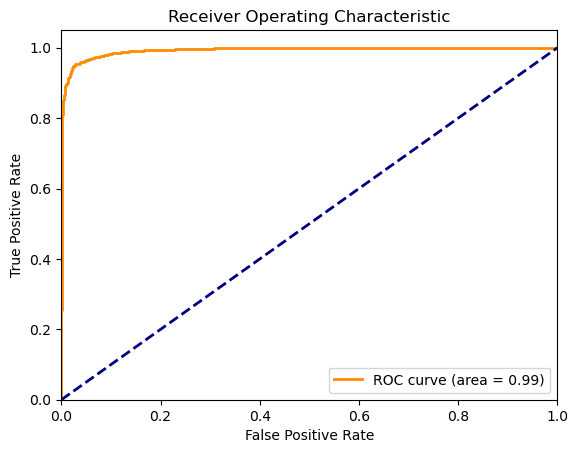

混淆矩阵：
[[ 944   51]
 [  64 1719]]
准确率 (Accuracy): 0.9586033117350612
精确率 (Precision): 0.9711864406779661
召回率 (Recall): 0.9641054402692092
F1分数 (F1 Score): 0.9676329862088376


In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import lightgbm as lgb
import matplotlib.pyplot as plt
import gc
import psutil

def get_date(filename):
    result = []
    for df in pd.read_csv(filename, chunksize=1000000):
        result.append(df)
    result = pd.concat(result, ignore_index=True, axis=0)
    return result

# 获取全量数据
train = get_date('./security_train.csv')
train.head(5)

# 查看内存使用情况
mem = psutil.virtual_memory()
print('总内存', mem.total / 1024 / 1024)
print('已使用内存', mem.used / 1024 / 1024)
print('剩余内存', mem.free / 1024 / 1024)
print('内存使用率', mem.percent)

# 标签编码
le = LabelEncoder()
train['api'] = le.fit_transform(train['api'])

# 特征提取
def get_features(df):
    df_file = df.groupby('file_id')
    # dfl作为最终结果
    dfl = df.drop_duplicates(subset=['file_id', 'label'], keep='first')
    dfl = dfl.sort_values(by='file_id')
    # 提取多个特征的统计特征 api、tid、index
    features = ['api', 'tid', 'index']
    for f in features:
        dfl[f + '_count'] = df_file[f].count().values
        dfl[f + '_nunique'] = df_file[f].nunique().values
        dfl[f + '_max'] = df_file[f].max().values
        dfl[f + '_min'] = df_file[f].min().values
        dfl[f + '_std'] = df_file[f].std().values
        dfl[f + '_mean'] = df_file[f].mean().values
        dfl[f + '_median'] = df_file[f].median().values
        dfl[f + '_ptp'] = dfl[f + '_max'] - dfl[f + '_min']
    return dfl

df = get_features(train)
df.head(5)

# 划分训练集和测试集
train_set, test_set = train_test_split(df, test_size=0.2, random_state=2024)

# 清理不需要的变量
gc.collect()

# 模型训练
clf = lgb.LGBMClassifier(
    num_leaves=2**5 - 1, reg_alpha=0.25, reg_lambda=0.25, objective='multiclass',
    max_depth=-1, learning_rate=0.005, min_child_samples=3, random_state=2024,
    n_estimators=2000, subsample=1, colsample_bytree=1)

clf.fit(train_set.drop(['file_id', 'label'], axis=1), train_set['label'])

# 预测
pred_probs = clf.predict_proba(test_set.drop(['file_id', 'label'], axis=1))

# 将多分类问题处理为二分类问题
test_set['binary_label'] = (test_set['label'] != 0).astype(int)
binary_preds = pred_probs[:, 1:].sum(axis=1)  # 非0标签的概率和作为恶意软件的概率

# 计算ROC曲线和AUC值
fpr, tpr, thresholds = roc_curve(test_set['binary_label'], binary_preds)
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# 计算混淆矩阵
binary_preds_label = (binary_preds >= 0.5).astype(int)
cm = confusion_matrix(test_set['binary_label'], binary_preds_label)
print('混淆矩阵：')
print(cm)

# 计算常见性能指标
accuracy = accuracy_score(test_set['binary_label'], binary_preds_label)
precision = precision_score(test_set['binary_label'], binary_preds_label)
recall = recall_score(test_set['binary_label'], binary_preds_label)
f1 = f1_score(test_set['binary_label'], binary_preds_label)

print('准确率 (Accuracy):', accuracy)
print('精确率 (Precision):', precision)
print('召回率 (Recall):', recall)
print('F1分数 (F1 Score):', f1)
